In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Defining class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot',
]

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader , random_split

data_dir = "/kaggle/working/fashionmnist"

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Seed for reproducibility
torch.manual_seed(7) #makes the training process reproducible

# Create training ,test and  validation datasets
trainset = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(data_dir, download=True, train=False, transform=transform)


total_size = len(trainset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

trainset, validset, testset = random_split(trainset, [train_size, val_size, test_size])

# Create data loaders for our datasets
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validloader = DataLoader(validset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('testing set has {} instances'.format(len(testset)))
print('Validation set has {} instances'.format(len(validset)))

100%|██████████| 26421880/26421880 [00:02<00:00, 11772831.72it/s]


Extracting /kaggle/working/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/fashionmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201652.52it/s]


Extracting /kaggle/working/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/fashionmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3752867.64it/s]


Extracting /kaggle/working/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/fashionmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4954629.87it/s]

Extracting /kaggle/working/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/fashionmnist/FashionMNIST/raw

Training set has 48000 instances
testing set has 6000 instances
Validation set has 6000 instances


In [7]:
def extract_images_labels(loader):
    images = []
    labels = []
    for batch in loader:
        b_images, b_labels = batch
        images.append(b_images)
        labels.append(b_labels)
    return torch.cat(images, dim=0), torch.cat(labels, dim=0)

# Extracting train and test images and labels
train_images, train_labels = extract_images_labels(trainloader)
valid_images, valid_labels = extract_images_labels(validloader)
valtest_images, test_labels = extract_images_labels(testloader)

In [8]:
train_images.shape


torch.Size([48000, 1, 28, 28])

In [9]:
train_images.dim()


4

In [10]:
len(train_labels)


48000

In [11]:
valid_images.shape

torch.Size([6000, 1, 28, 28])

In [12]:
len(valid_labels)


6000

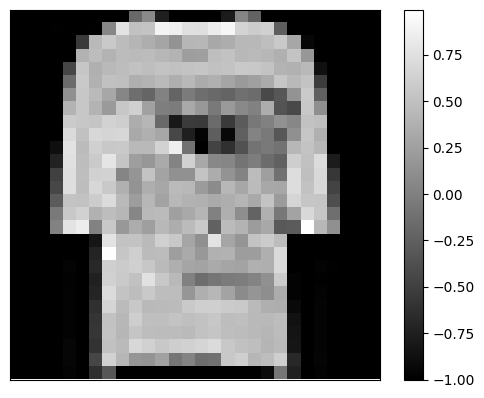

In [13]:
# Plotting firt image
plt.figure()
plt.imshow(train_images[0][0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

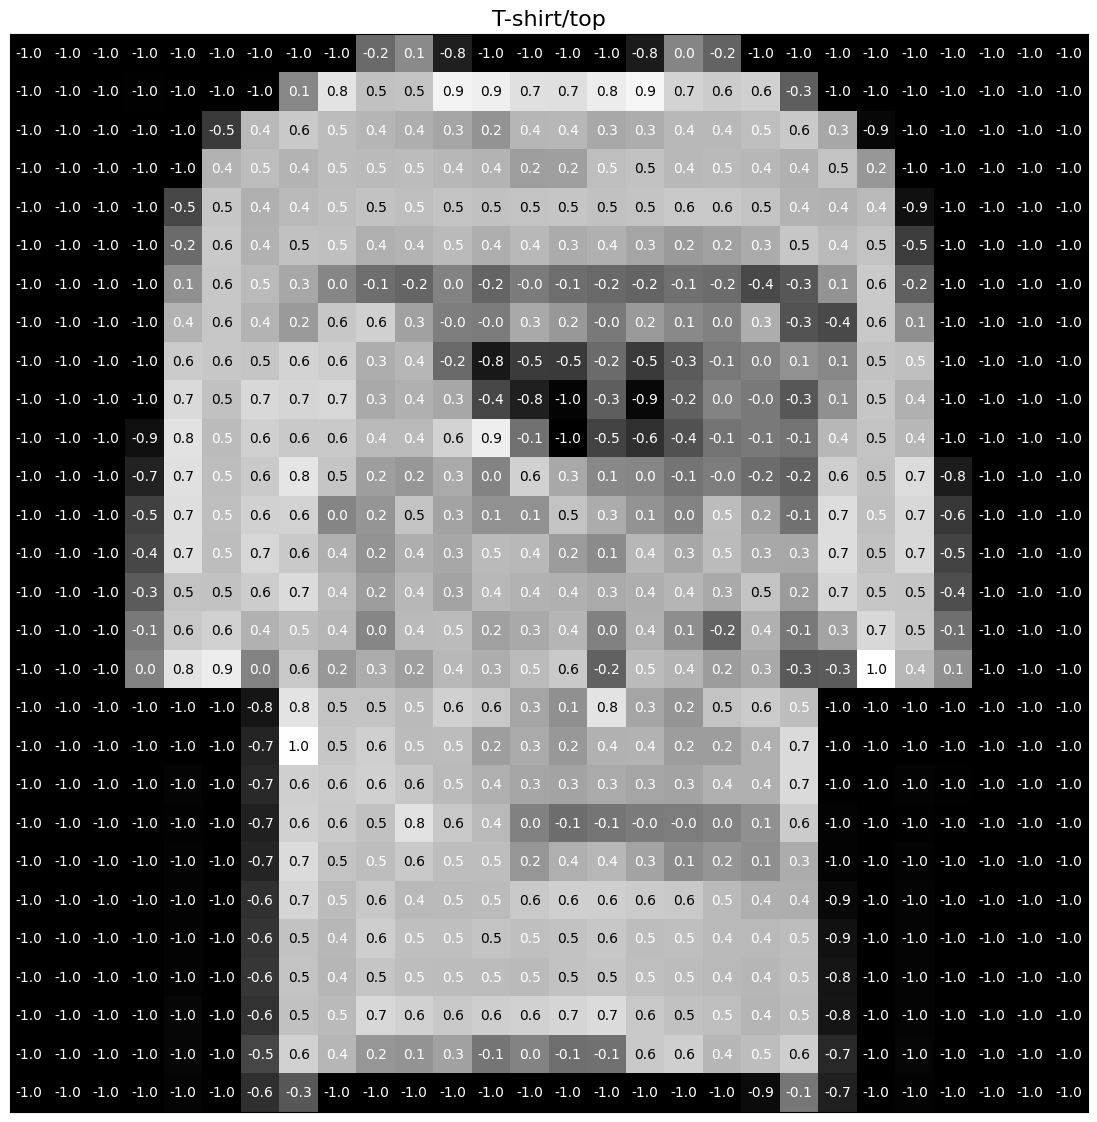

In [14]:
def get_text_color(value:float) -> str:
    """Returns 'white' for dark pixels and 'black' for light pixels."""
    return 'white' if value < 0.5 else 'black'

image_numpy = train_images[0][0].squeeze().numpy()
label = train_labels[0]

# Plotting the image
plt.figure(figsize=(14,14))
plt.imshow(image_numpy, cmap='gray')
plt.title(class_names[label], fontsize=16,)
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Overlaying the pixel values
for i in range(image_numpy.shape[0]):
    for j in range(image_numpy.shape[1]):
        plt.text(j, i, '{:.1f}'.format(image_numpy[i,j]), ha='center', va='center', color=get_text_color(image_numpy[i,j]))
plt.show()

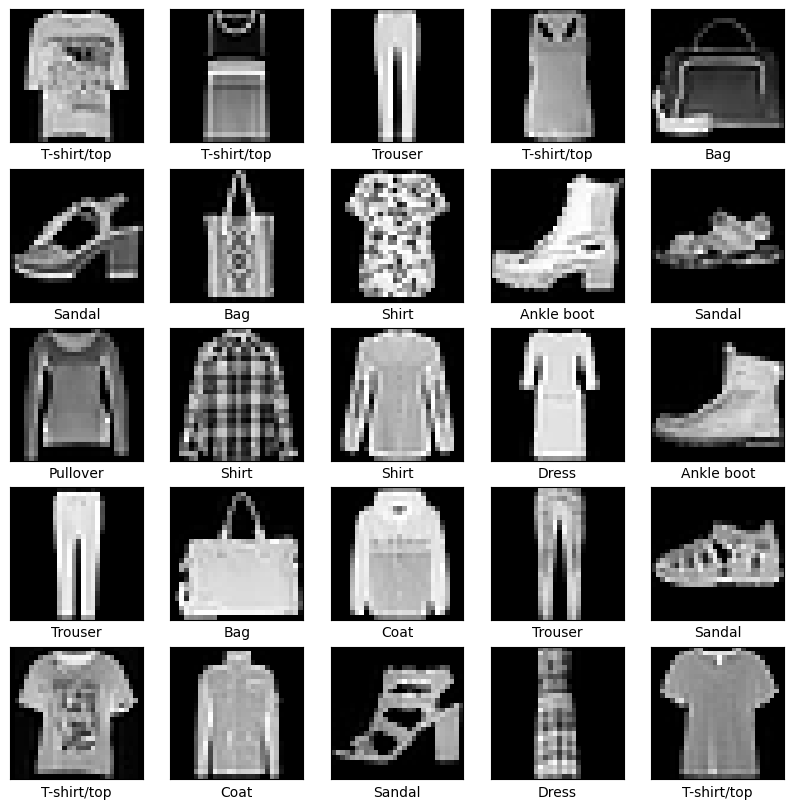

In [15]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap='gray')
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [16]:
#Flatten the images
def flatten_images(images):
    return images.view(images.size(0), -1)



normal the pixel


In [17]:
# Normalize the pixel values
def normalize(images):
    return images / 255.0

In [18]:

import torch.nn as nn
# Step 3: Model Architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_function=nn.ReLU()):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(activation_function)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Specify the input size based on the flattened image dimensions
input_size = 28 * 28
# Choose an appropriate number of neurons for each layer
hidden_sizes = [256, 128]
# Specify the number of classes for the output layer
output_size = 10

model = MLP(input_size, hidden_sizes, output_size)


In [19]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [20]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in trainloader:
        images = flatten_images(images)
        images = normalize(images)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

This code evaluates the model on the test set and reports its accuracy. The images are flattened and normalized before being fed into the model during evaluation.

In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images = flatten_images(images)
        images = normalize(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.2%}")

Accuracy on the test set: 86.12%


In [22]:
model.eval()
images, labels = next(iter(testloader))
images = flatten_images(images)
images = normalize(images)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

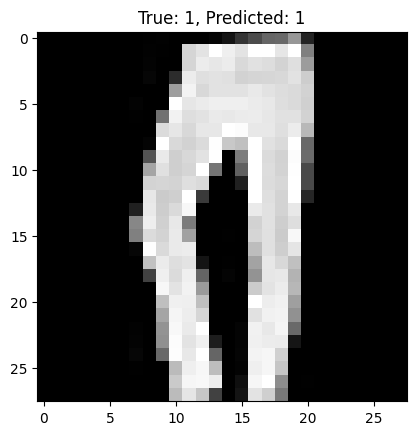

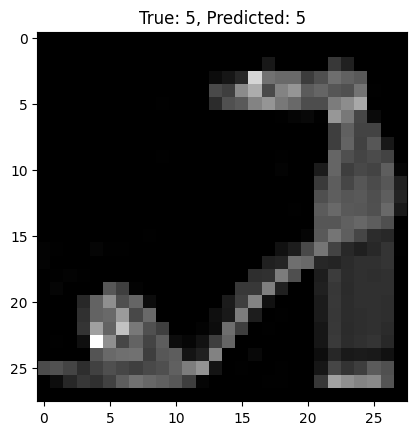

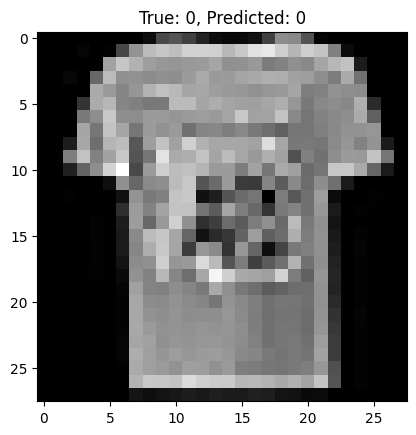

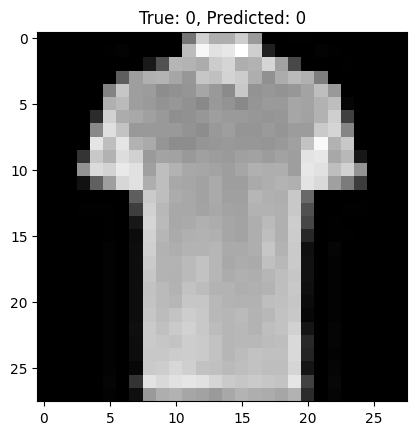

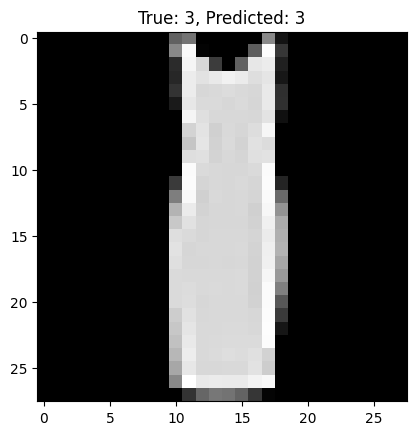

In [23]:
for i in range(5):
    plt.imshow(images[i].view(28, 28).cpu(), cmap='gray')
    plt.title(f"True: {labels[i]}, Predicted: {predicted[i]}")
    plt.show()